In [69]:
%matplotlib inline
import matplotlib.pyplot as plt
from bitalg.tests.test3 import Test
from bitalg.visualizer.main import Visualizer

In [70]:
def draw_polygon(polygon):
    vis = Visualizer()
    vis.add_polygon(polygon, fill=False)
    vis.show()

# Wczytywanie wilokątów

In [71]:
def save_polygon_to_file(polygon, file_path):
    with open(file_path, 'w') as file:
        for item in polygon:
            file.write(f"{item[0]} {item[1]}\n")

def read_polygon_from_file(file_path):
    polygon = []
    with open(file_path, 'r') as file:
        for line in file:
            polygon.append(list(map(lambda x: float(x), line.split())))
    
    return polygon

Funkcja wczytująca wielokąt od użytkownika 

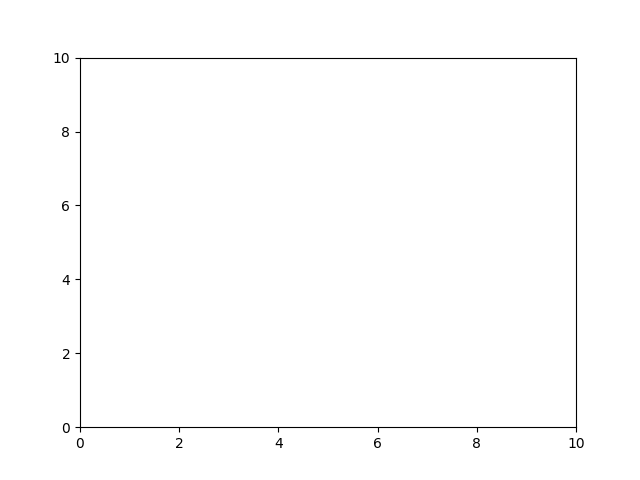

In [99]:
%matplotlib widget
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlim([0, 10])
ax.set_ylim([0, 10])

given_polygon = []
points_x = []
points_y = []
eps = 0.1
finished = False

def onclick(event):
    global finished, given_polygon
    if len(points_x) > 0 and abs(points_x[0] - event.xdata) < eps and abs(points_y[0] - event.ydata) < eps: 
        given_polygon = list(zip(points_x, points_y))
        points_x.append(points_x[0])
        points_y.append(points_y[0])
        finished = True
    if not finished:
        points_x.append(event.xdata)
        points_y.append(event.ydata)
        col = 'blue'
    else:
        col = 'green'
    plt.plot(points_x, points_y, '.', c=col)
    plt.plot(points_x, points_y, c=col)

cid = fig.canvas.mpl_connect('button_press_event', onclick)
plt.show()

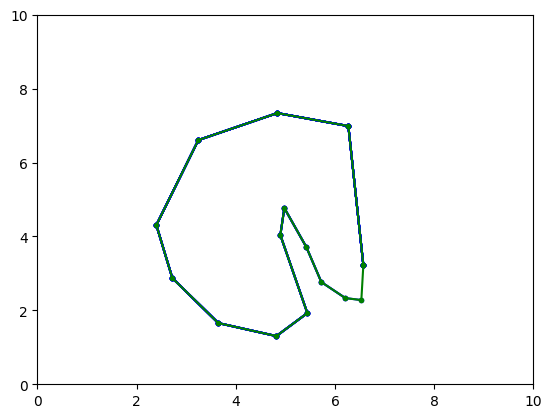

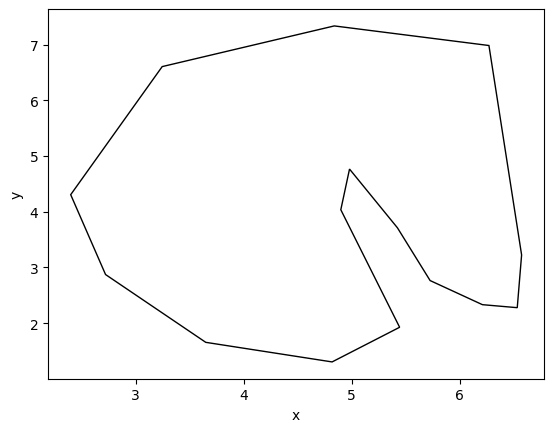

In [100]:
%matplotlib inline
draw_polygon(given_polygon)
save_polygon_to_file(given_polygon, "polygon.txt")

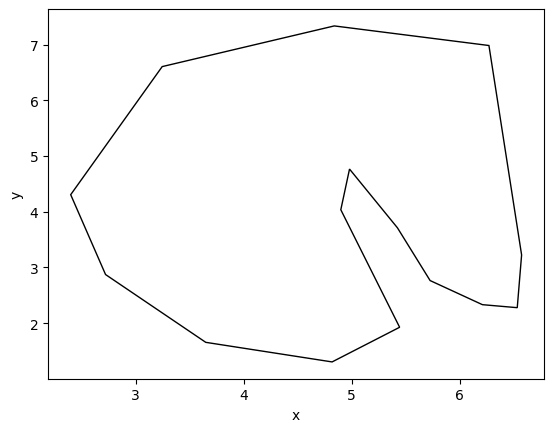

In [101]:
p = read_polygon_from_file("polygon.txt")
draw_polygon(p)

# Triangulacja wielokątów monotonicznych - problem monitorowania galerii


## Przydatne funkcje


In [75]:
polygon_example_1 = [(5,5), (3,4), (6,3), (4,2), (6,0), (7,1), (8,4)]
polygon_example_2 = [(2,0), (5,1), (6,0), (8,3), (7,2), (8,7), (6,9), (5,8), (2,9), (1,7), (2,4), (4,5), (3,6), (5, 7), (5.5, 3), (2,2), (1,3), (0,1)]
polygon_example_colors = [1, 3, 1, 0, 2, 4, 0, 2, 0, 4, 1, 4, 4, 3, 4, 2, 0, 4]
polygon_example_tri = [(polygon_example_1[0], polygon_example_1[2]),
                      (polygon_example_1[2], polygon_example_1[5]),
                      (polygon_example_1[2], polygon_example_1[6]),
                      (polygon_example_1[6], polygon_example_1[3]),
                      (polygon_example_1[2], polygon_example_1[4]),]
       

In [76]:
def draw_polygon_colors(polygon,colors):
    points_start=[]
    points_end=[]
    points_connect=[]
    points_divide=[]
    points_regular=[]
    for i in range(len(polygon)):
        if colors[i]==0:
            points_start.append(polygon[i])
        elif colors[i]==1:
            points_end.append(polygon[i])
        elif colors[i]==2:
            points_connect.append(polygon[i])
        elif colors[i]==3:
            points_divide.append(polygon[i])
        elif colors[i]==4:
            points_regular.append(polygon[i])

    vis = Visualizer()
    colors_start = ['green']
    color_end=['red']
    color_connect=['blue']
    color_divide=['cyan']
    color_regular=['#3B240B']
    vis.add_polygon(polygon, fill=False)
    vis.add_point(points_start, color=colors_start)
    vis.add_point(points_end, color=color_end)
    vis.add_point(points_connect, color=color_connect)
    vis.add_point(points_divide, color=color_divide)
    vis.add_point(points_regular, color=color_regular)
    vis.show()


In [77]:
def draw_polygon_tri(polygon,tri):

    vis = Visualizer()
    points = polygon
    tri_line_segments = tri
    vis.add_polygon(points, fill=False)
    vis.add_point(points)
    vis.add_line_segment(tri_line_segments, color='red')
    vis.show()

## Wprowadzenie
Celem ćwiczenia jest:
- sprawdzanie $y$-monotoniczności
- podział wierchołków na kategorie
- triangulacja wielokąta monotonicznego

### Przykładowy wielokąt $y$-monotoniczny

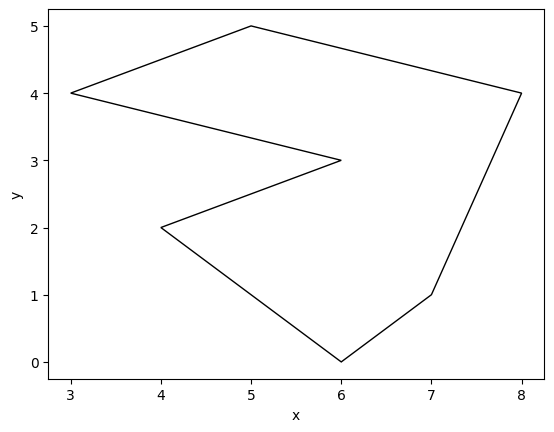

In [78]:
draw_polygon(polygon_example_1)

Do tego celu wygeneruj wielokąt.

In [79]:
polygon = [(0,0), (3,2), (-1, 4)]

## Czy wielokąt jest $y$-monotoniczny?

Wielokąt jest monotoniczny, gdy jego wierzchołki mogą być ułożone w taki sposób, że jedna z jego współrzędnych (na przykład współrzędna $x$ lub $y$, w zależności od układu współrzędnych) zawsze rośnie lub maleje wzdłuż kolejnych wierzchołków. Innymi słowy, dla każdej pary wierzchołków wielokąta (oprócz wierzchołka startowego i końcowego), jeden z punktów ma większą (lub mniejszą) wartość danej współrzędnej niż drugi punkt.

W praktyce, wielokąt monotoniczny może być łatwiej sortowany lub przetwarzany w pewnych algorytmach geometrycznych, ponieważ istnieje pewna kolejność, w jakiej wierzchołki pojawiają się wzdłuż danej osi (np. osi $x$ lub $y$). Monotoniczność może ułatwić znajdowanie przecięć linii w takim wielokącie lub wykonywanie innych operacji geometrycznych. W tym zadaniu interesuje nas monotoniczność wielokąta wzdłuż osi $y$.

<span style="color:red">Ćw.</span> Uzupełnij funkcję ```is_y_monotonic```. Pamiętaj, aby sprawozdanie zawierało krótki opis działania tej funkcji.

In [80]:
EPS = 1e-12

def orient(a, b, c):   
    a_x, a_y = a
    b_x, b_y = b
    c_x, c_y = c 
    return (a_x - c_x) * (b_y - c_y) - (a_y - c_y) * (b_x - c_x)

def is_connective_or_separative(a, b, c):
    global EPS
    det = orient(a, b, c)
    if a[1] > b[1] and c[1] > b[1] and det < -EPS:
        return True
    elif a[1] < b[1] and c[1] < b[1] and det < -EPS:
        return True
    return False

In [81]:
def is_y_monotonic(polygon):
    """
    Funkcja określa czy podana figura jest y-monotoniczna.
    :param polygon: tablica krotek punktów na płaszczyźnie euklidesowej podanych przeciwnie do ruchu wskazówek zegara - nasz wielokąt
    :return: wartość bool - true, jeśli wielokąt jest monotoniczny i false jeśli nie jest
    """
    for i in range(1, len(polygon)-1):
        if is_connective_or_separative(polygon[i-1], polygon[i], polygon[i+1]):
            return False
    
    if len(polygon) > 2 and is_connective_or_separative(polygon[-2], polygon[-1], polygon[0]):
        return False
    return True

Przeprowadź test poprawności powyższej funkcji.

In [82]:
Test().runtest(1, is_y_monotonic)

Lab 3, task 1:
	Test 1: Passed
	Test 2: Passed
	Test 3: Passed
	Test 4: Passed
	Test 5: Passed
	Test 6: Passed
	Test 7: Passed
	Test 8: Passed
	Test 9: Passed
	Test 10: Passed
Result: 10/10
Time: 0.044s


Sprawdź monotoniczność swojego wielokątu.

In [83]:
print(is_y_monotonic(polygon))
print(is_y_monotonic(given_polygon))

True
True


***

# Podział wierzchołków na kategorie

Wierzchołki naszego wielokąta możemy podzielić na parę kategorii:
- początkowe, gdy obaj jego sąsiedzi leżą poniżej i kąt wewnętrzny ma mniej niż 180 stopni. To wierzchołki, w których wielokąt zaczyna się monotoniczny spadek 
- końcowe, gdy obaj jego sąsiedzi leżą powyżej i kąt wewnętrzny ma mniej niż 180 stopni. To wierzchołki, w których monotoniczność wielokąta się zmienia, czyli na przykład zaczyna się monotoniczny wzrost, jeśli wcześniej był spadek, lub na odwrót.

Wierzchołki startowe i końcowe są ważne w kontekście algorytmów przetwarzania wielokątów monotonicznych, takich jak algorytmy dziel i zwyciężaj oraz triangulacji. 
- dzielący, gdy obaj jego sąsiedzi leżą poniżej i kąt wewnęntrzny ma więcej niż 180 stopni. To wierzchołki, które wyznaczają przekątne (linie łączące), tworzące trójkąty podczas triangulacji.
- łączący, gdy obaj jego sąsiedzi leżą powyżej i kąt wewnęntrzny ma więcej niż 180 stopni. To wierzchołki, które są połączone liniami (przekątnymi) wewnątrz wielokąta, tworząc trójkąty.

Wierzchołki łączące i dzielące odgrywają kluczową rolę w procesie triangulacji wielokątów, pozwalając na podział figury na trójkąty w sposób bezkolizyjny. 
- prawdiłowy, pozostałe przypadki, jeden sąsiad powyżej drugi poniżej


### Przykładowy wielokąt z pokolorowanymi wierzchołkami.

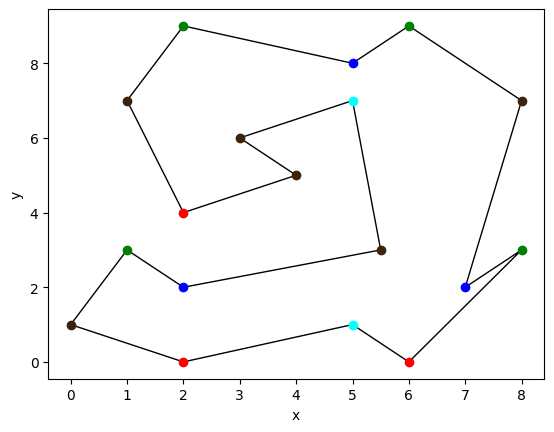

In [84]:
draw_polygon_colors(polygon_example_2,polygon_example_colors)

<span style="color:red">Ćw.</span> Uzupełnij funkcję ```color_vertex``` .

In [85]:
def color_vertex(polygon):
    """
    Funkcja dzieli wierzchołki na kategorie i przypisuje wierzchołkom odpowiednie numery: 0 - początkowy, 1 - końcowy, 2 - łączący, 3 - dzielący, 4 - prawdiłowy
    :param polygon: tablica krotek punktów na płaszczyźnie euklidesowej podanych przeciwnie do ruchu wskazówek zegara - nasz wielokąt
    :return: tablica o długości n, gdzie n = len(polygon), zawierająca cyfry z przedziału 0 - 4, gdzie T[i] odpowiada kategorii i-tego wierzchołka.
    """
    global EPS
    
    if len(polygon) == 1: return [0]
    if len(polygon) == 2: return [0, 1] if polygon[0][1] > polygon[1][1] else [1, 0]

    colors = [4]*len(polygon)
    for i in range(len(polygon)):
        a = polygon[i-1] if i > 0 else polygon[-1]
        b = polygon[i]
        c = polygon[i+1] if i < len(polygon)-1 else polygon[0]
        det = orient(a, b, c)
        if a[1] < b[1] and c[1] < b[1] and det > EPS:
            colors[i] = 0
        elif a[1] > b[1] and c[1] > b[1] and det > EPS:
            colors[i] = 1
        elif a[1] > b[1] and c[1] > b[1] and det < -EPS:
            colors[i] = 2
        elif a[1] < b[1] and c[1] < b[1] and det < -EPS:
            colors[i] = 3
    
    return colors

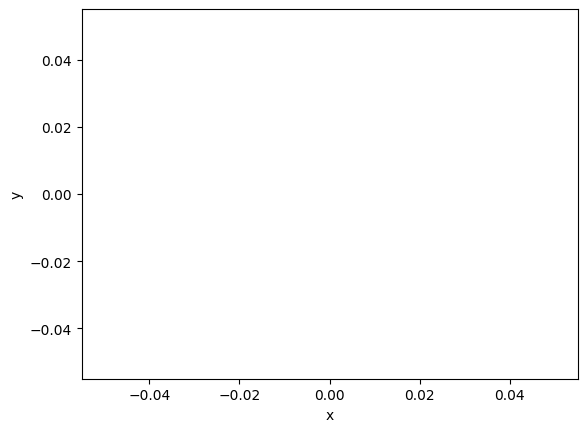

In [86]:
col = color_vertex(given_polygon)
draw_polygon_colors(given_polygon, col)

Przeprowadź test poprawności powyższej funkcji. 

In [87]:
Test().runtest(2, color_vertex)

Lab 3, task 2:
	Test 1: Passed
	Test 2: Passed
	Test 3: Passed
	Test 4: Passed
	Test 5: Passed
	Test 6: Passed
	Test 7: Passed
	Test 8: Passed
	Test 9: Passed
	Test 10: Passed
Result: 10/10
Time: 0.033s


Zwizualizuj swój wielokąt z pokolorowanymi według kategorii wierzchołkami.

***

# Triangulacja wielokąta monotonicznego

Triangulacja wielokąta monotonicznego to proces podziału wielokąta monotonicznego na trójkąty poprzez dodawanie przekątnych (linii łączących wierzchołki), które nie przecinają się wewnętrznie.

<span style="color:red">Ćw.</span> Uzupełnij funkcję ```triangulation```. Wykorzystaj algorytm opisany na wykładzie.

In [88]:
def get_point_side(polygon): # right = 0, left = 1
    sides = [0]*len(polygon)
    colors = color_vertex(polygon)

    start = colors.index(0)
    end = colors.index(1)

    if end >= start:
        for i in range(start + 1, end):
            sides[i] = 1
    else:
        for i in range(start + 1, len(polygon)):
            sides[i] = 1
        for i in range(0, end - 1):
            sides[i] = 1
    
    
    sides[start] = 1
    sides[end] = 0
    
    return sides, end

def inside_polygon(a, b, c, chain_side):
    if chain_side == 1:
        return orient(a, b, c) > 0
    else:
        return orient(a, b, c) < 0

def is_neighbour(a_idx, b_idx, n):
    if abs(a_idx - b_idx) == 1:
        return True
    elif abs(a_idx - b_idx) == n - 1:
        return True
    return False
    

In [89]:
def sort_points(points, which_chain):
    left, right = [], []
    start = points.index(max(points, key=lambda x: x[1]))
        
    for i in range(start, len(points)):
        if which_chain[i] == 1: left.append(i)
        else: right.append(i)
    
    for i in range(0, start):
        right.append(i)
    
    right = right[::-1]
    
    i = 0
    j = 0

    res = []
    while i < len(left) and j < len(right):
        if points[left[i]][1] > points[right[j]][1]:
            res.append(left[i])
            i += 1
        else:
            res.append(right[j])
            j += 1
    
    if i < len(left):
        res.extend(left[i:len(left)])
    if j < len(right):
        res.extend(right[j:len(right)])
        
    return res

In [106]:
test_index = 1
SAVE_CHARTS = False
def triangulation(polygon):
    global test_index
    """
    Funkcja dokonuje triangulacji wielokąta monotonicznego. 
    :param polygon: tablica krotek punktów na płaszczyźnie euklidesowej podanych przeciwnie do ruchu wskazówek zegara - nasz wielokąt
    :return: tablica krotek dodawanych po kolei przekątnych np: [(1,5),(2,3)], oznacza, że triangulacja polega na dodaniu przekątnej pomiędzy wierzchołki 1-5 i 2-3
    """
    if not is_y_monotonic(polygon): 
        print("Wielokąt nie jest y-monotoniczny")
        return []
    
    triangles = []
    diags = []
    vis = Visualizer()

    chain_side, end_point = get_point_side(polygon)
    points = sort_points(polygon, chain_side)

    Q = []
    Q_points = []
    current_point = None
    n = len(polygon)
    vis.add_polygon(polygon, fill=False)

    if SAVE_CHARTS:
        vis.save(f'{test_index}_start')
    Q.append(points[0])
    Q.append(points[1])
    Q_points.append(vis.add_point(polygon[points[0]], color='green'))
    Q_points.append(vis.add_point(polygon[points[1]], color='green'))
    for i in range(2, n):
        if current_point != None: vis.remove_figure(current_point)
        current_point = vis.add_point(polygon[points[i]], color='blue')
        if chain_side[points[i]] != chain_side[Q[-1]]:
            prev_last = Q[-1]
            while len(Q) > 0:
                p = Q.pop()
                vis.remove_figure(Q_points.pop())
                if not is_neighbour(points[i], p, n):
                    diags.append((points[i], p))
                    triangles.append((points[i], p, Q[-1]))
                    vis.add_line_segment((polygon[points[i]], polygon[p]), color='red')
            if i < n -1:
                Q.append(prev_last)
                Q.append(points[i])
                Q_points.append(vis.add_point(polygon[prev_last], color='green'))
                Q_points.append(vis.add_point(polygon[points[i]], color='green'))
        else:
            p = Q.pop()
            vis.remove_figure(Q_points.pop())
            while len(Q) > 0 and inside_polygon(polygon[Q[-1]], polygon[p], polygon[points[i]], chain_side[p]):
                if not is_neighbour(Q[-1], points[i], n):
                    diags.append((Q[-1], points[i]))
                    triangles.append((Q[-1], p, points[i]))
                    vis.add_line_segment((polygon[Q[-1]], polygon[points[i]]), color='red')
                p = Q.pop()
                vis.remove_figure(Q_points.pop())

            if i < n -1:
                Q.append(p)
                Q.append(points[i])
                Q_points.append(vis.add_point(polygon[p], color='green'))
                Q_points.append(vis.add_point(polygon[points[i]], color='green'))
    
    triangles.append((diags[-1][0], diags[-1][1], end_point))
    vis.remove_figure(current_point)
    if SAVE_CHARTS:
        vis.save(f'{test_index}_end')
        vis.save_gif(f'{test_index}')
    test_index += 1
    return diags


Jakich struktur można użyć do przechowywania wielokątu, oraz utworzonej triangulacji? Uzasadnij wybór struktury w swoim algorytmie

ODPOWIEDŹ: 

Przeprowadź testy poprawności powyższej funkcji.


In [98]:
test_index = 1
Test().runtest(3, triangulation)

Lab 3, task 3:
	Test 1: Passed
	Test 2: Passed
	Test 3: Passed
	Test 4: Passed
	Test 5: Passed
	Test 6: Passed
	Test 7: Passed
	Test 8: Passed
	Test 9: Passed
	Test 10: Passed
Result: 10/10
Time: 0.101s


Zwizualizuj powstały wielokąt podzielony na trójkąty.

Wielokąt nie jest y-monotoniczny


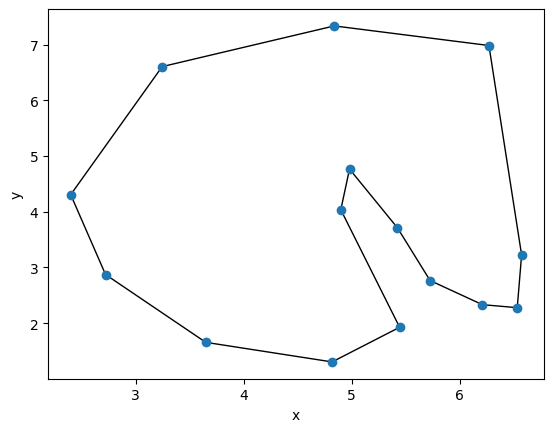

In [107]:
tri = triangulation(given_polygon)
tri_p = []
for i, j in tri:
    tri_p.append((given_polygon[i], given_polygon[j]))
    
draw_polygon_tri(given_polygon, tri_p)